### import libraries

In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
from shapeGMM import gmm_shapes
import os
import sys
import pickle
import glob

### load D. E. Shaw MD trajectory of HP35(Nle/Nle) mutant

In [2]:
# read trajectory data
data_path = '/scratch/work/hockygroup/gmh4/projects/gmm_clustering/data/DESRES-Trajectory_pnas2012-2f4k-360K-protein/pnas2012-2f4k-360K-protein/'
backbone_selection_101 = "(name C and resid 42) or (name C CA N and not resid 42 76) or (name N and resid 76)"
# LOAD DATA
prmtopFileName =  data_path + 'pnas2012-2f4k-360K-protein.pdb'
# make an ordered list of all the files
trajFiles = sorted(glob.glob(data_path+"*.dcd"))
#print(trajFiles)
#print(len(trajFiles))
coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)
trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0
for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

Number of atoms in trajectory: 577
Number of frames in trajectory: 1526041
Number of atoms being analyzed: 101
Number of frames being analyzed: 1526041


### Load the shapeGMM object (shared by Martin)

In [3]:
# loading the object from pickled file
with open("hp35_wsgmm_6_clusters_reorderd.pickle", "rb")as f_o:
    wsgmm = pickle.load(f_o)

### save the cluster centers and precisions 

### load cluster labels 

In [4]:
clusters = np.loadtxt("hp35_wsgmm_6_clusters_reorderd_full_traj.clusters")
print(clusters.shape)

(1526041,)


In [5]:
print("Number of Training frames :", wsgmm.n_frames)
print("Train log likelihood per frame :", wsgmm.log_likelihood/wsgmm.n_frames)

Number of Training frames : 61042
Train log likelihood per frame : 379.8134702799295


### check the cluster populations

In [6]:
cluster_ids, cluster_populations = np.unique(clusters,return_counts=True)
n_clusters = cluster_ids.size

print("Total no. of clusters =", n_clusters)
print("Cluster ID:", cluster_ids)
print("Populations of clusters:", cluster_populations)

Total no. of clusters = 6
Cluster ID: [0. 1. 2. 3. 4. 5.]
Populations of clusters: [513969 326358 203663 167295 157838 156918]


### Choosing the folded and unfolded states

1. We will consider the most populated state as native or folded state and least populated state as unfolded state.
2. According to the population data shown above, cluster-id=0 is folded while cluster-id= 4 or 5 might correspond to unfolded state.

In [7]:
# extracting out frames belonging to different clusters

folded_frames = trajData[[x[0] for x in np.argwhere(clusters == 0)]]
print(folded_frames.shape)

c4_frames = trajData[[x[0] for x in np.argwhere(clusters == 4)]]
print(c4_frames.shape)

c5_frames = trajData[[x[0] for x in np.argwhere(clusters == 5)]]
print(c5_frames.shape)

(513969, 101, 3)
(157838, 101, 3)
(156918, 101, 3)


### Radius of gyration calculation

In [8]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

$\textbf{Plot $R_g$ data}$

(1526041, 4)


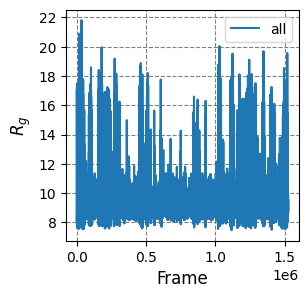

In [9]:
# load the data
rog_data = np.load("rog-data.npy", allow_pickle=True)
print(rog_data.shape)
# make plot
plt.figure(figsize=(3,3))
plt.plot(np.arange(coord.trajectory.n_frames, dtype=int), rog_data[:,0], label="all")
#plt.plot(np.arange(coord.trajectory.n_frames, dtype=int), rog_data[:,1], label="x-axis")
plt.xlabel("Frame", fontsize=12)
plt.ylabel("$R_g$", fontsize=12)
plt.grid(axis="both", which="major", linestyle="--", color="gray")
plt.legend()

### plot $R_{g}$ only for cluster 4 and 5 

c4_rog_avg = 9.718790162176692
c5_rog_avg = 9.135078311305163


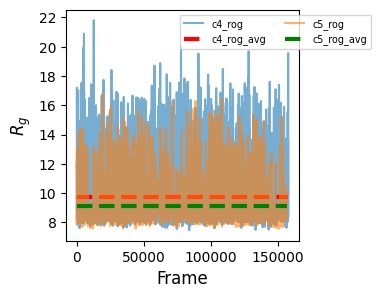

In [10]:
c4_rog = rog_data[:,0][[x[0] for x in np.argwhere(clusters == 4)]]
c5_rog = rog_data[:,0][[x[0] for x in np.argwhere(clusters == 5)]]

c4_rog_avg = np.mean(c4_rog)
print("c4_rog_avg =", c4_rog_avg)
c5_rog_avg = np.mean(c5_rog)
print("c5_rog_avg =", c5_rog_avg)


plt.figure(figsize=(3,3))
plt.xlabel("Frame", fontsize=12)
plt.ylabel("$R_g$", fontsize=12)
plt.plot(c4_rog, alpha=0.6, label="c4_rog")
plt.hlines(y=c4_rog_avg, xmin=0, xmax=len(c4_rog), colors='r', linestyle="--", linewidth=3.0, label="c4_rog_avg")
plt.plot(c5_rog, alpha=0.6, label="c5_rog")
plt.hlines(y=c5_rog_avg, xmin=0, xmax=len(c5_rog), colors='g', linestyle="--", linewidth=3.0, label="c5_rog_avg")
plt.legend(ncol=2, fontsize='x-small', bbox_to_anchor=[0.9,1.0], loc="upper center")

### Let's calculate the RMSDs w.r.t Helix-1/2/3 

### plot RMSD data

(1526040, 3)


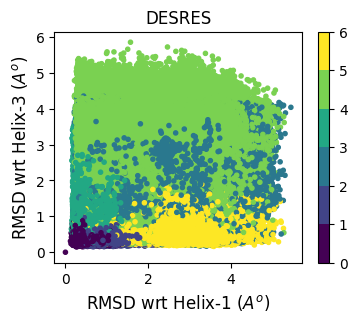

In [11]:
desres_rmsd_data = np.load("desres_rmsd_data.npy", allow_pickle=True)
print(desres_rmsd_data.shape)

import matplotlib as mpl

rmsd_h1_desres = desres_rmsd_data[:,0]
rmsd_h2_desres = desres_rmsd_data[:,1]
rmsd_h3_desres = desres_rmsd_data[:,2]

bounds = np.arange(7)
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(4,3))
plt.title("DESRES", fontsize=12)
plt.xlabel("RMSD wrt Helix-1 ($A^o$)", fontsize=12)
plt.ylabel("RMSD wrt Helix-3 ($A^o$)",fontsize=12)
plt.scatter(rmsd_h1_desres, rmsd_h3_desres, c=clusters[1::], norm=norm, marker=".")
cbar=plt.colorbar()

$\textbf{Now we can say that, based on the Plots above we choose c=0 (folded state) and c=4(unfolded state)}$

### Aligning the MD trajectory

In [12]:
from shapeGMM import _traj_tools as traj_tools

### Align to folded state (c=0)

### Align to unfolded state (c=4)

### Global Alignment 

### loading the aligned trajs

In [13]:
folded_aligned_traj = np.load("folded_aligned_traj.npy", allow_pickle=True)
unfolded_aligned_traj = np.load("unfolded_aligned_traj.npy", allow_pickle=True)
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)

print(global_aligned_traj.shape)
print(folded_aligned_traj.shape)
print(unfolded_aligned_traj.shape)

(1526041, 101, 3)
(1526041, 101, 3)
(1526041, 101, 3)


### extracting folded and unfolded frames only from multiple alignment trajs

In [14]:
folded_aligned_traj_frames = np.concatenate([folded_aligned_traj[[x[0] for x in np.argwhere(clusters == 0)]],\
                                             folded_aligned_traj[[x[0] for x in np.argwhere(clusters == 4)]]], axis=0)


unfolded_aligned_traj_frames = np.concatenate([unfolded_aligned_traj[[x[0] for x in np.argwhere(clusters == 0)]],\
                                             unfolded_aligned_traj[[x[0] for x in np.argwhere(clusters == 4)]]], axis=0)


global_aligned_traj_frames = np.concatenate([global_aligned_traj[[x[0] for x in np.argwhere(clusters == 0)]],\
                                             global_aligned_traj[[x[0] for x in np.argwhere(clusters == 4)]]], axis=0)

### compute committor 

In [16]:
# setting the traj labels for each frame
traj_labels = np.zeros(coord.trajectory.n_frames)
print(traj_labels.shape)

for i in range(len(traj_labels)):
    
    # folded state
    if clusters[i] == 0:
        
        # assign 1 to folded state
        traj_labels[i] = 1
        
    # unfolded state
    elif clusters[i] == 4:
        
        # assign 0 to unfolded state
        traj_labels[i] = 0
    
    else:
        
        # assign 2 to any other frames
        traj_labels[i] = 2

print(np.unique(traj_labels))
# save the traj labels
np.savetxt('traj_labels.txt', traj_labels, fmt="%1.1f")

(1526041,)
[0. 1. 2.]


### plot conmittor

1526041


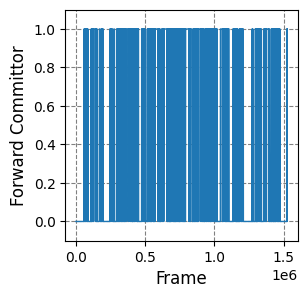

In [17]:
import compute_committor_modf
import importlib
importlib.reload(compute_committor_modf)
comm = compute_committor_modf.b_before_a(traj_labels,state_a=0,state_b=1)
print(len(comm))

#save the committor 
np.savetxt('comm.dat', comm, fmt="%1.1f")

# make a plot for committor
plt.figure(figsize=(3,3))
# no -ve values are presesnt in committor data (good point!) 
plt.plot(comm, lw=1.0)  
plt.ylim(-0.1, 1.1)
plt.xlabel("Frame", fontsize=12)
plt.ylabel("Forward Committor", fontsize=12)
plt.grid(which='major', axis='both', color='#808080', linestyle="--")

## Linear Discriminant Analysis

$\textit{First We are going to use only two states (folded and unfolded) with weighted alignment}$

### Folded / Unfolded states (Global Alignment)

In [18]:
# assign 0 to unfolded frames and 1 to folded frames
f_c = np.ones(folded_frames.shape[0])

u_c = np.zeros(c4_frames.shape[0])

clusters_assigned = np.concatenate([f_c, u_c], axis=0)

print(clusters_assigned.shape)

(671807,)


Text(0.5, 1.0, 'Global Alignment')

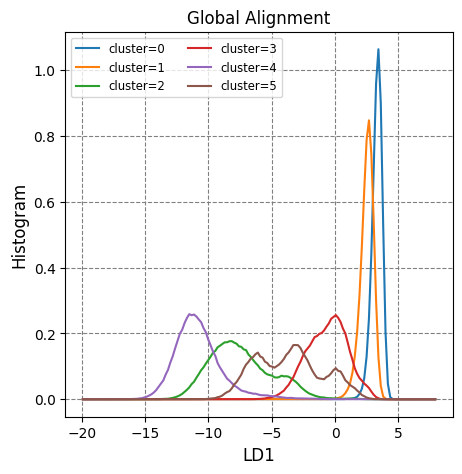

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-20,8)
nbins = 150

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj_frames.reshape(global_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_sgmm3 = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

# save 
#np.savetxt("lda_scalings_global_folded_unfolded_ld1.txt", lda.scalings_[:,0])


plt.figure(figsize=(5,5))                   

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y_pred_sgmm3[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    #plot it
    plt.plot(grids, hist_i, label="cluster=%d"%i)
    #plt.fill_between(grids, hist_i)
    
plt.grid(axis="both", which="major", color='#808080', linestyle='--')
plt.legend(loc="upper left", ncol=2, fontsize="small", markerscale=1.0)
plt.xlabel("LD1", fontsize=12)
plt.ylabel("Histogram", fontsize=12)
plt.title("Global Alignment", fontsize=12)

### Histogram LD1 (2 states) for different alignments

(0.0, 1.2)

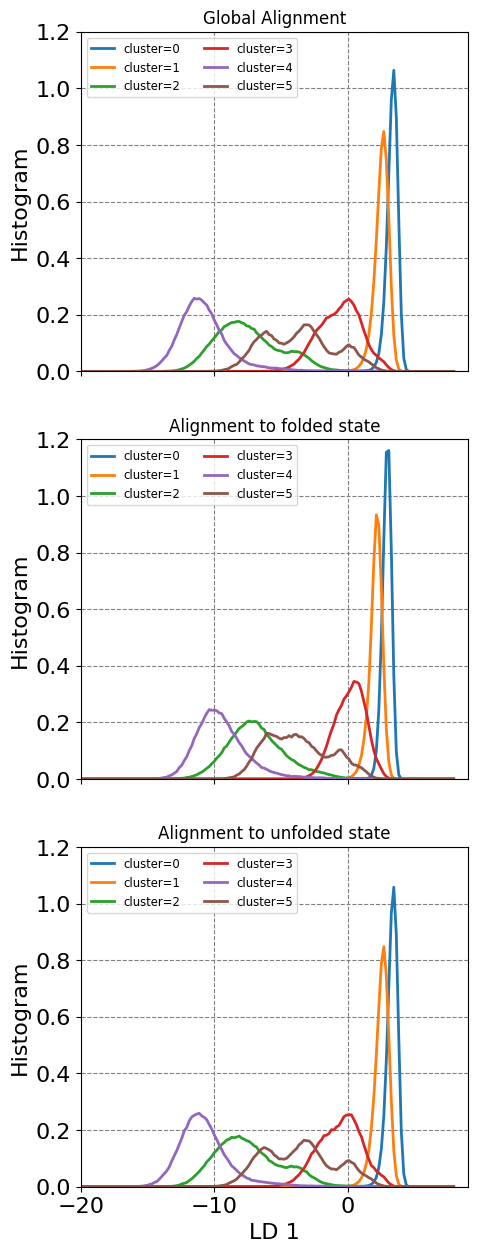

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-20,8)
#nbins = 25
nbins=150    # looks better!!

fig, axes = plt.subplots(3, 1, figsize=(5, 15), dpi=100,sharey=True,sharex=True)
#=========================================================================================#
# 00
axes[0].set_title("Global Alignment")
axes[0].set_ylabel("Histogram",fontsize=16)
axes[0].tick_params(axis='both',labelsize=16)
axes[0].grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj_frames.reshape(global_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_sgmm3 = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y_pred_sgmm3[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    #plot it
    axes[0].plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)
    #axes[0].fill_between(grids, hist_i)
axes[0].legend(loc="upper left", ncol=2, fontsize="small", markerscale=1.0)

# set lims
axes[0].set_xlim(-20,9)
axes[0].set_ylim(0.0, 1.20)

#=========================================================================================#
# 01
axes[1].set_title("Alignment to folded state")
axes[1].set_ylabel("Histogram",fontsize=16)
axes[1].tick_params(axis='both',labelsize=16)
axes[1].grid(which='major', axis='both', color='#808080', linestyle='--')
# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(folded_aligned_traj_frames.reshape(folded_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_gmm3 = lda.transform(folded_aligned_traj.reshape(folded_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y_pred_gmm3[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    #plot it
    axes[1].plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)
    #axes[1].fill_between(grids, hist_i)
axes[1].legend(loc="upper left", ncol=2, fontsize="small", markerscale=1.0)

# set lims
axes[1].set_xlim(-20,9)
axes[1].set_ylim(0.0,1.20)

#=========================================================================================#
# 10
axes[2].set_title("Alignment to unfolded state")
axes[2].set_xlabel("LD 1",fontsize=16)
axes[2].set_ylabel("Histogram",fontsize=16)
axes[2].tick_params(axis='both',labelsize=16)
axes[2].grid(which='major', axis='both', color='#808080', linestyle='--')
# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(unfolded_aligned_traj_frames.reshape(unfolded_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_gmm3 = lda.transform(unfolded_aligned_traj.reshape(unfolded_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y_pred_gmm3[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    #plot it
    axes[2].plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)
    #axes[2].fill_between(grids, hist_i)
axes[2].legend(loc="upper left", ncol=2, fontsize="small", markerscale=1.0)

# set lims
axes[2].set_xlim(-20,9)
axes[2].set_ylim(0.0,1.20)

### Calculate FE vs. LD1 (colored with committor probability) for different alignments

3.3075437533720806 -10.770378206621357
2.903223503479354 -9.453787306350083
3.300864215496867 -10.748627580016118


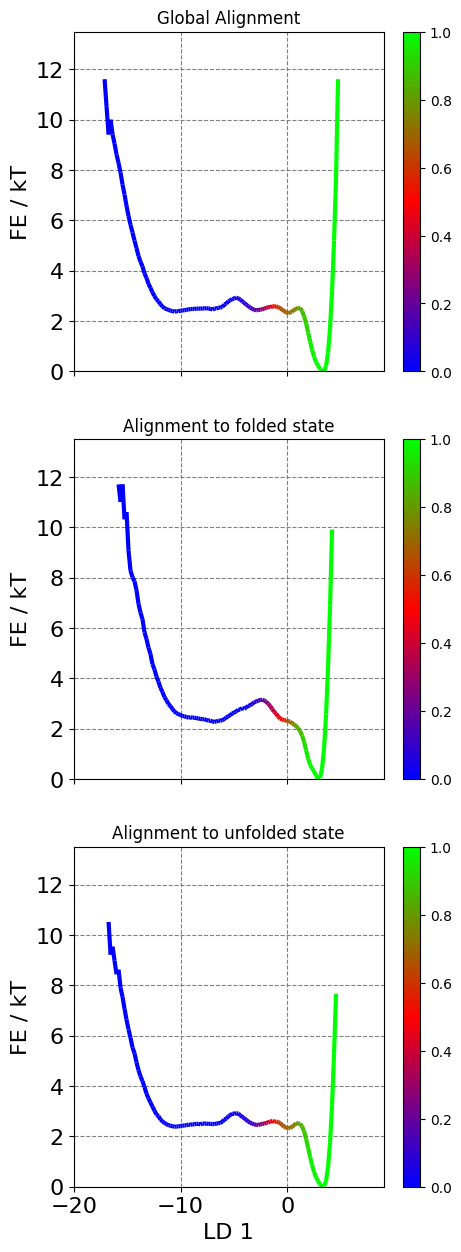

In [25]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cmap = 'brg'

ld_range = (-20,8)
nbins = 150

#ld_range = (-15,5)  # another choice
#nbins = 100

fig, axes = plt.subplots(3, 1, figsize=(5, 15), dpi=100,sharey=True,sharex=True)
#=========================================================================================#
# 00
axes[0].set_title("Global Alignment")
axes[0].set_ylabel("FE / kT",fontsize=16)
axes[0].tick_params(axis='both',labelsize=16)
axes[0].grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj_frames.reshape(global_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_sgmm3 = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

# calculate avg. LD1 values for folded and unfolded states
folded_ld1_avg = np.mean(y_pred_sgmm3[[x[0] for x in np.argwhere(clusters == 0)]])
unfolded_ld1_avg = np.mean(y_pred_sgmm3[[x[0] for x in np.argwhere(clusters == 4)]])
print(folded_ld1_avg, unfolded_ld1_avg)

# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_sgmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_sgmm3[1::] >=my_bin) * (y_pred_sgmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[0].set_xlim(-20,9)
axes[0].set_ylim(0.0, 13.5)

# Create a continuous norm to map from data points to colors
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[0].add_collection(lc)
fig.colorbar(line, ax=axes[0])

# save FE data
out = np.array([grids, fe-fe.min()]).T
np.savetxt("fe_vs_ld1_2_states_global_alignment.txt", out)

#=========================================================================================#
# 01
axes[1].set_title("Alignment to folded state")
axes[1].set_ylabel("FE / kT",fontsize=16)
axes[1].tick_params(axis='both',labelsize=16)
axes[1].grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(folded_aligned_traj_frames.reshape(folded_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_gmm3 = lda.transform(folded_aligned_traj.reshape(folded_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

# calculate avg. LD1 values for folded and unfolded states
folded_ld1_avg = np.mean(y_pred_gmm3[[x[0] for x in np.argwhere(clusters == 0)]])
unfolded_ld1_avg = np.mean(y_pred_gmm3[[x[0] for x in np.argwhere(clusters == 4)]])
print(folded_ld1_avg, unfolded_ld1_avg)

# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_gmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1]+bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_gmm3[1::] >=my_bin) * (y_pred_gmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[1].set_xlim(-20,9)
axes[1].set_ylim(0.0,13.5)

# Create a continuous norm to map from data points to colors
norm2 = plt.Normalize(0.0, 1.0) # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm2)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[1].add_collection(lc)
fig.colorbar(line, ax=axes[1])

#=========================================================================================#
# 10
axes[2].set_title("Alignment to unfolded state")
axes[2].set_xlabel("LD 1",fontsize=16)
axes[2].set_ylabel("FE / kT",fontsize=16)
axes[2].tick_params(axis='both',labelsize=16)
axes[2].grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(unfolded_aligned_traj_frames.reshape(unfolded_aligned_traj_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_gmm3 = lda.transform(unfolded_aligned_traj.reshape(unfolded_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

# calculate avg. LD1 values for folded and unfolded states
folded_ld1_avg = np.mean(y_pred_gmm3[[x[0] for x in np.argwhere(clusters == 0)]])
unfolded_ld1_avg = np.mean(y_pred_gmm3[[x[0] for x in np.argwhere(clusters == 4)]])
print(folded_ld1_avg, unfolded_ld1_avg)

# histogramming the lda and caluclate free energy
hist, bins = np.histogram(y_pred_gmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1]+bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_gmm3[1::] >=my_bin) * (y_pred_gmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[2].set_xlim(-20,9)
axes[2].set_ylim(0.0,13.5)

# Create a continuous norm to map from data points to colors
norm3 = plt.Normalize(0.0,1.0)   # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm3)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[2].add_collection(lc)
fig.colorbar(line, ax=axes[2])

###  All states (using Global Alignment)

$\textit{Here we are using all 6 states and weighted alignment}$

### histogram LD1 

Text(0.5, 1.0, 'Global Alignment')

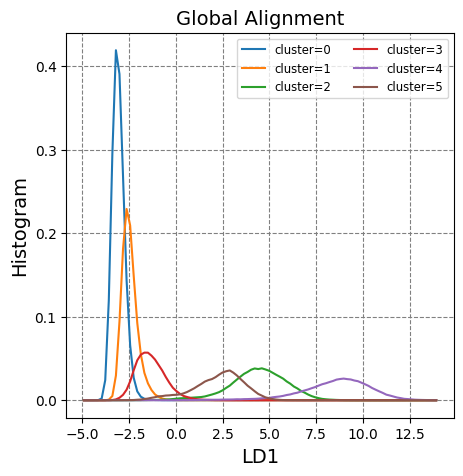

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-5,14)
nbins = 100

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), clusters)
y_pred_sgmm3 = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

#np.savetxt("lda_scalings_global_6_states.txt", lda.scalings_[:,0])

plt.figure(figsize=(5,5))                   

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y_pred_sgmm3[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    plt.plot(grids, hist_i*weight, label="cluster=%d"%i)
    #plt.fill_between(grids, hist_i)
    
plt.grid(axis="both", which="major", color='#808080', linestyle='--')
plt.legend(loc="upper right", ncol=2, fontsize="small", markerscale=1.0)
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Histogram", fontsize=14)
plt.title("Global Alignment", fontsize=14)

### FE vs. LD1 

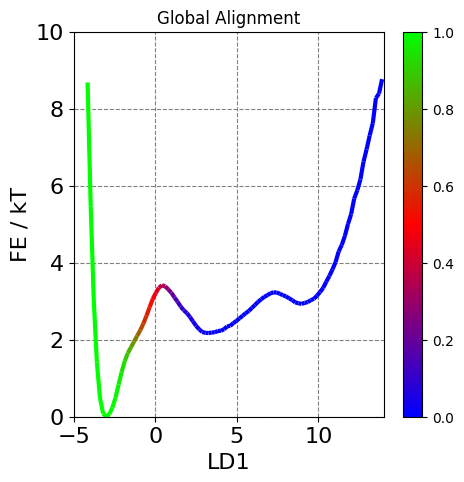

In [29]:
from matplotlib.collections import LineCollection
cmap = 'brg'

# here using y_pred_sgmm3 form the previous cell (please check that)
hist, bins = np.histogram(y_pred_sgmm3, range=(-5,14), bins=100, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_sgmm3[1::] >=my_bin) * (y_pred_sgmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

axes.set_title("Global Alignment")
axes.set_ylabel("FE / kT",fontsize=16)
axes.set_xlabel("LD1", fontsize=16)
axes.tick_params(axis='both',labelsize=16)
axes.grid(which='major', axis='both', color='#808080', linestyle='--')
axes.set_xlim(-5,14)
axes.set_ylim(0,10)

# Create a continuous norm to map from data points to colors
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes.add_collection(lc)
fig.colorbar(line, ax=axes)

# save FE data
out = np.array([grids, fe-fe.min()]).T
#np.savetxt("fe_vs_ld1_6_states_global_alignment.txt", out)

### histogram LD2

Text(0.5, 1.0, 'Global Alignment')

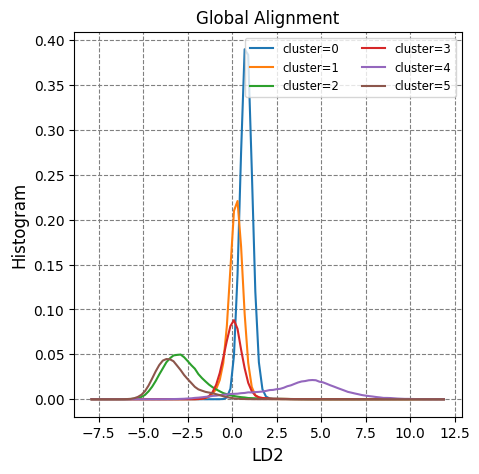

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-8,12)
nbins = 100

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), clusters)
y_pred_sgmm3 = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,1]

#np.savetxt("lda_scalings_global_6_states_ld2.txt", lda.scalings_[:,1])

plt.figure(figsize=(5,5))      

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y_pred_sgmm3[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    plt.plot(grids, hist_i*weight, label="cluster=%d"%i)
    #plt.fill_between(grids, hist_i)
    
plt.grid(axis="both", which="major", color='#808080', linestyle='--')
plt.legend(loc="upper right", ncol=2, fontsize="small", markerscale=1.0)
plt.xlabel("LD2", fontsize=12)
plt.ylabel("Histogram", fontsize=12)
plt.title("Global Alignment", fontsize=12)

### FE vs. LD2

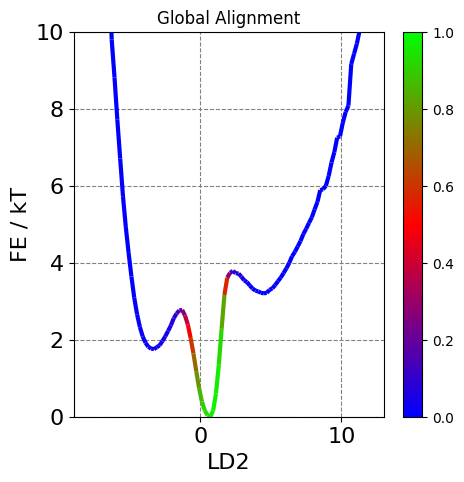

In [33]:
from matplotlib.collections import LineCollection
cmap = 'brg'

# here using y_pred_sgmm3 form the previous cell (please check that)
hist, bins = np.histogram(y_pred_sgmm3, range=(-8,12), bins=100, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_sgmm3[1::] >=my_bin) * (y_pred_sgmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

axes.set_title("Global Alignment")
axes.set_ylabel("FE / kT",fontsize=16)
axes.set_xlabel("LD2", fontsize=16)
axes.tick_params(axis='both',labelsize=16)
axes.grid(which='major', axis='both', color='#808080', linestyle='--')
axes.set_xlim(-9,13)
axes.set_ylim(0,10)

# Create a continuous norm to map from data points to colors
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes.add_collection(lc)
fig.colorbar(line, ax=axes)

### Calculate FE vs. LD1 (colored with committor probability) for different alignments

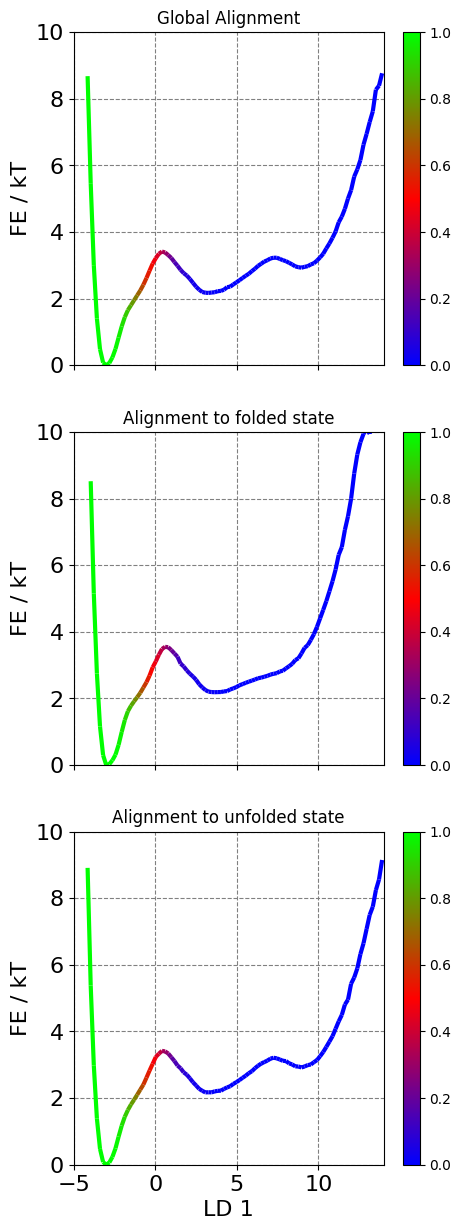

In [35]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cmap = 'brg'

ld_range = (-5,14)
nbins = 100

fig, axes = plt.subplots(3, 1, figsize=(5, 15), dpi=100,sharey=True,sharex=True)
#=========================================================================================#
# 00
axes[0].set_title("Global Alignment")
axes[0].set_ylabel("FE / kT",fontsize=16)
axes[0].tick_params(axis='both',labelsize=16)
axes[0].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_sgmm3 = lda.fit_transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_sgmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_sgmm3[1::] >=my_bin) * (y_pred_sgmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[0].set_xlim(-5,14)
axes[0].set_ylim(0.0, 10.0)

# Create a continuous norm to map from data points to colors
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[0].add_collection(lc)
fig.colorbar(line, ax=axes[0])

#=========================================================================================#
# 01
axes[1].set_title("Alignment to folded state")
axes[1].set_ylabel("FE / kT",fontsize=16)
axes[1].tick_params(axis='both',labelsize=16)
axes[1].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_gmm3 = lda.fit_transform(folded_aligned_traj.reshape(folded_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_gmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1]+bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_gmm3[1::] >=my_bin) * (y_pred_gmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[1].set_xlim(-5,14)
axes[1].set_ylim(0.0,10)

# Create a continuous norm to map from data points to colors
norm2 = plt.Normalize(0.0, 1.0) # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm2)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[1].add_collection(lc)
fig.colorbar(line, ax=axes[1])

#=========================================================================================#
# 10
axes[2].set_title("Alignment to unfolded state")
axes[2].set_xlabel("LD 1",fontsize=16)
axes[2].set_ylabel("FE / kT",fontsize=16)
axes[2].tick_params(axis='both',labelsize=16)
axes[2].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_gmm3 = lda.fit_transform(unfolded_aligned_traj.reshape(unfolded_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

# histogramming the lda and caluclate free energy
hist, bins = np.histogram(y_pred_gmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1]+bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_gmm3[1::] >=my_bin) * (y_pred_gmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[2].set_xlim(-5,14)
axes[2].set_ylim(0.0,10.0)

# Create a continuous norm to map from data points to colors
norm3 = plt.Normalize(0.0,1.0)   # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm3)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[2].add_collection(lc)
fig.colorbar(line, ax=axes[2])

### All states (using uniform alignment)

$\textit{Here we are using all 6 states and uniform alignment}$

### perform iterative uniform alignment (using digaonal sigma^-2 x I_3N precision matrix)

In [39]:
# load aligned trajs
uniform_aligned_trajectory = np.load("uniform_aligned_trajectory.npy", allow_pickle=True)

folded_aligned_traj_uniform = np.load("folded_aligned_traj_uniform.npy", allow_pickle=True)

unfolded_aligned_traj_uniform = np.load("unfolded_aligned_traj_uniform.npy", allow_pickle=True)

### histogram LD1

Text(0.5, 1.0, 'Global Alignment')

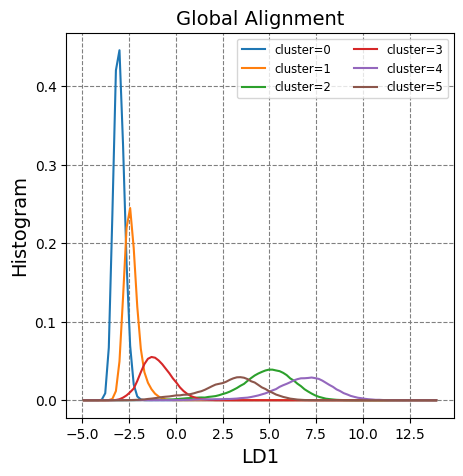

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-5,14)
nbins = 100

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_sgmm3 = lda.fit_transform(uniform_aligned_trajectory.reshape(uniform_aligned_trajectory.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

plt.figure(figsize=(5,5))                   

# looping over clusters
for i in range(n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = y_pred_sgmm3[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    plt.plot(grids, hist_i*weight, label="cluster=%d"%i)
    #plt.fill_between(grids, hist_i)
    
plt.grid(axis="both", which="major", color='#808080', linestyle='--')
plt.legend(loc="upper right", ncol=2, fontsize="small", markerscale=1.0)
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Histogram", fontsize=14)
plt.title("Global Alignment", fontsize=14)

### FE vs. LD1

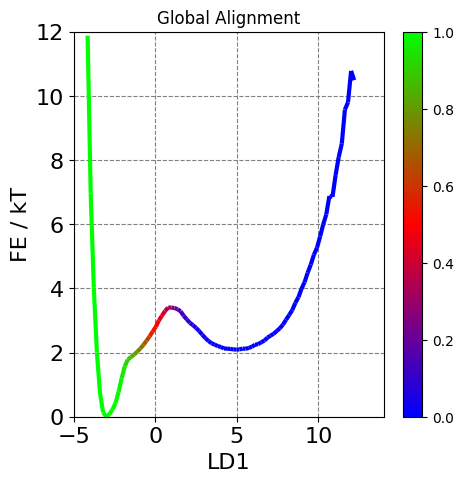

In [37]:
# here using y_pred_sgmm3 form the previous cell (please check that)
hist, bins = np.histogram(y_pred_sgmm3, range=(-5,14), bins=100, density=True)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_sgmm3[1::] >=my_bin) * (y_pred_sgmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

axes.set_title("Global Alignment")
axes.set_ylabel("FE / kT",fontsize=16)
axes.set_xlabel("LD1", fontsize=16)
axes.tick_params(axis='both',labelsize=16)
axes.grid(which='major', axis='both', color='#808080', linestyle='--')
axes.set_xlim(-5,14)
axes.set_ylim(0,12)

# Create a continuous norm to map from data points to colors
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes.add_collection(lc)
fig.colorbar(line, ax=axes)

### calculate FE vs. LD1 (colored with committor probability) using different UNIFORM alignments

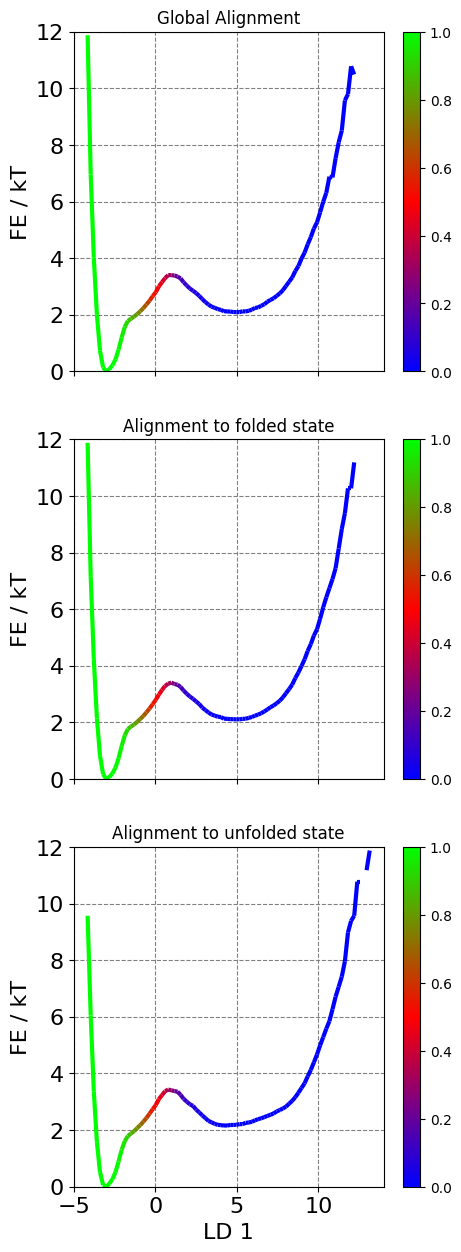

In [40]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cmap = 'brg'

ld_range = (-5,14)
nbins = 100

fig, axes = plt.subplots(3, 1, figsize=(5, 15), dpi=100,sharey=True,sharex=True)
#=========================================================================================#
# 00
axes[0].set_title("Global Alignment")
axes[0].set_ylabel("FE / kT",fontsize=16)
axes[0].tick_params(axis='both',labelsize=16)
axes[0].grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_sgmm3 = lda.fit_transform(uniform_aligned_trajectory.reshape(uniform_aligned_trajectory.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_sgmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_sgmm3[1::] >=my_bin) * (y_pred_sgmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[0].set_xlim(-5,14)
axes[0].set_ylim(0.0, 12.0)

# Create a continuous norm to map from data points to colors
norm1 = plt.Normalize(0.0, 1.0)  # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm1)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[0].add_collection(lc)
fig.colorbar(line, ax=axes[0])

#=========================================================================================#
# 01
axes[1].set_title("Alignment to folded state")
axes[1].set_ylabel("FE / kT",fontsize=16)
axes[1].tick_params(axis='both',labelsize=16)
axes[1].grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_gmm3 = lda.fit_transform(folded_aligned_traj_uniform.reshape(folded_aligned_traj_uniform.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_gmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1]+bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_gmm3[1::] >=my_bin) * (y_pred_gmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[1].set_xlim(-5,14)
axes[1].set_ylim(0.0,12.0)

# Create a continuous norm to map from data points to colors
norm2 = plt.Normalize(0.0, 1.0) # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm2)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[1].add_collection(lc)
fig.colorbar(line, ax=axes[1])

#=========================================================================================#
# 10
axes[2].set_title("Alignment to unfolded state")
axes[2].set_xlabel("LD 1",fontsize=16)
axes[2].set_ylabel("FE / kT",fontsize=16)
axes[2].tick_params(axis='both',labelsize=16)
axes[2].grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_gmm3 = lda.fit_transform(unfolded_aligned_traj_uniform.reshape(unfolded_aligned_traj_uniform.shape[0], sel_backbone_101.n_atoms*3), clusters)[:,0]

# histogramming the lda and caluclate free energy
hist, bins = np.histogram(y_pred_gmm3, range=ld_range, bins=nbins, density=True)
fe = -np.log(hist)
grids = (bins[:-1]+bins[1:])/2

# calculating average committor and variance values
dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (y_pred_gmm3[1::] >=my_bin) * (y_pred_gmm3[1::] <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe-fe.min()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# set lims
axes[2].set_xlim(-5,14)
axes[2].set_ylim(0.0,12.0)

# Create a continuous norm to map from data points to colors
norm3 = plt.Normalize(0.0,1.0)   # setting the limit [0,1]
lc = LineCollection(segments, cmap=cmap, norm=norm3)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(3)
line = axes[2].add_collection(lc)
fig.colorbar(line, ax=axes[2])